# Chest X-Ray Medical Diagnosis with Deep Learning

## Imports

In [1]:
import os

# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

2025-03-01 16:22:16.128042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740846136.141382    9588 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740846136.145788    9588 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [4]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [5]:
# !pip install hydra-core

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.IMAGES_DIR)

datasets/images-small/


In [7]:
IMAGE_DIR = Path(cfg.DATASET_DIRS.IMAGES_DIR)
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)

DENSENET_WEIGHT_PATH = cfg.PRETRAIN_MODEL.DENSENET_WEIGHT_PATH

BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
IMAGE_SIZE = cfg.TRAIN.IMG_SIZE

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [8]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

### Total Labels

In [10]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels), labels[:3]

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14,
 ['Atelectasis', 'Cardiomegaly', 'Consolidation'])

In [11]:
labels = labels[:3]
train_df_labels = train_df[labels]
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [12]:
valid_df_labels = valid_df[labels]
test_df_labels = test_df[labels]

## Data Leakage Prevent

check if there are patients in both train and test or in both valid and test.

In [13]:
def check_for_dataleakage(df1, df2, patentId_col='PatientId'):
    """
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    df1_patients_unique = df1[patentId_col].unique()
    df2_patients_unique = df2[patentId_col].unique()

    patients_in_common = np.intersect1d(df1_patients_unique, df2_patients_unique)

    leakage = True if (len(patients_in_common) > 0) else False
    return leakage

In [14]:
check_for_dataleakage(train_df, valid_df)

True

In [15]:
check_for_dataleakage(train_df, test_df)

False

In [16]:
check_for_dataleakage(test_df, valid_df)

False

### Load Training Dataset from Dataframe

Check for images

In [17]:
def is_image_exists(df):
    temp_df = df.copy() 
    for idx, image_path in enumerate(df.Image.values):
        # tf.io.read_file(f"{IMAGE_DIR/image_path}")
        if not Path(f"{IMAGE_DIR/image_path}").exists():
            print(f"Image {IMAGE_DIR/image_path} does not exist :{idx=}")
            temp_df = temp_df.drop(idx)

    return temp_df

In [18]:
len(is_image_exists(valid_df))

200

In [19]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    label = tf.cast(label, tf.float32)
    return image, label


In [20]:
train_df_labels

,Atelectasis,Cardiomegaly,Consolidation
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
995,0,0,0
996,0,0,0
997,0,0,0
998,0,0,0


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_df.Image.values,  train_df_labels.values))
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)

I0000 00:00:1740846139.668662    9588 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7362 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [22]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.Image.values,  valid_df_labels.values))
valid_ds = valid_ds.map(load_image, num_parallel_calls=AUTOTUNE)

In [23]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.190008  11.190008  

### Normalization

## Image Processing

In [24]:
# Create normalization layer
normalization_layer = tf.keras.layers.Normalization()
# Compute the mean and variance using the training data
# We need to convert the dataset to numpy to compute statistics
images_for_stats = []
for images, _ in train_ds.take(int(len(train_df)*0.25)): 
    images_for_stats.append(images)
images_for_stats = tf.concat(images_for_stats, axis=0)
normalization_layer.adapt(images_for_stats)

### Augmentation 

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.05, 0.05),           # Translation
    tf.keras.layers.RandomContrast(0.1),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.1),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.1, 0.1)])                   # Random zoom

In [26]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) #/ 255.0
    # mean, varience = tf.nn.moments(image, axes=[0, 1, 2])
    # image = (image - mean) / tf.math.sqrt(varience + 1e-7)
    image = tf.keras.applications.densenet.preprocess_input(image)
    # image = normalization_layer(image)
    return image, label

In [27]:
train_ds = train_ds.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_image,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).shuffle(BATCH_SIZE*4)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [28]:
for batch in train_ds.take(1):
    print(batch[0].shape)
    # image, label = batch
    print(image, label)

(32, 320, 320, 3)
tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.1

In [29]:
valid_ds = valid_ds.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### Class Imbalance Handling

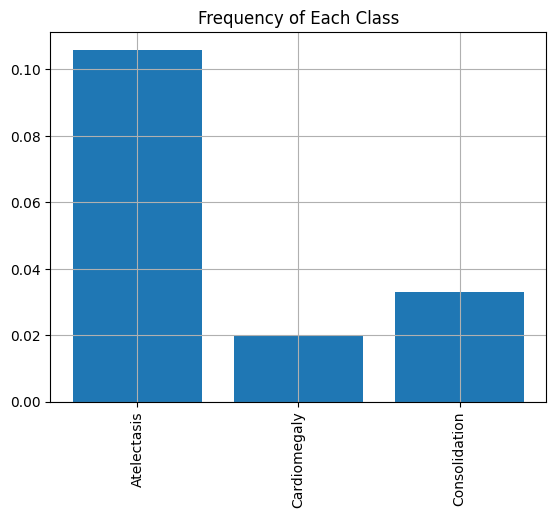

In [30]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_df_labels, axis=0))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

#### Compute Class Frequencies

In [31]:
N = train_df_labels.shape[0]
positive_frequencies = (train_df_labels==1).sum()/N
negative_frequencies = (train_df_labels==0).sum()/N
positive_frequencies, negative_frequencies

(Atelectasis      0.106
 Cardiomegaly     0.020
 Consolidation    0.033
 dtype: float64,
 Atelectasis      0.894
 Cardiomegaly     0.980
 Consolidation    0.967
 dtype: float64)

In [32]:
data_df = pd.DataFrame(list(positive_frequencies.items()), columns=['class', 'positives'])
data_df['negatives'] = negative_frequencies.values
data_df

,class,positives,negatives
0,Atelectasis,0.106,0.894
1,Cardiomegaly,0.020,0.980
2,Consolidation,0.033,0.967


<Axes: xlabel='class'>

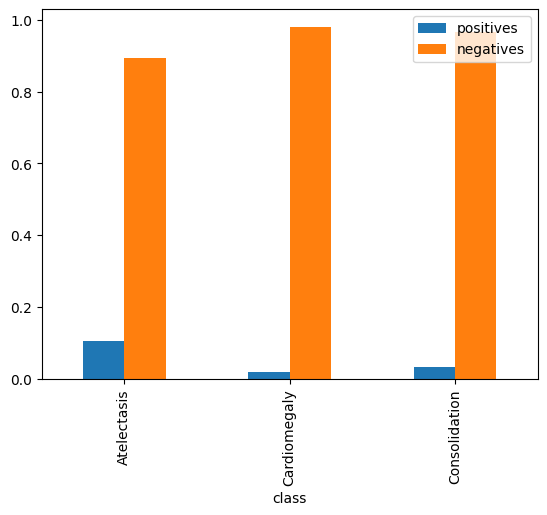

In [33]:
data_df.plot.bar(x='class')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [34]:
pos_weights = negative_frequencies.values
neg_weights = positive_frequencies.values
# positive_frequencies.values

# Try adjusting the weight balance slightly
# pos_weights = np.sqrt(negative_frequencies.values) * 0.8  # Reduce positive weight slightly
# neg_weights = np.sqrt(positive_frequencies.values) * 1.2  # Increase negative weight slightly

In [35]:
pos_contirbution = positive_frequencies * pos_weights
neg_contribution = negative_frequencies * neg_weights

pos_contirbution, neg_contribution

(Atelectasis      0.094764
 Cardiomegaly     0.019600
 Consolidation    0.031911
 dtype: float64,
 Atelectasis      0.094764
 Cardiomegaly     0.019600
 Consolidation    0.031911
 dtype: float64)

In [36]:
weighted_data_df = pd.DataFrame(list(pos_contirbution.items()), columns=['class', 'positives'])
weighted_data_df['negatives'] = neg_contribution.values
weighted_data_df

,class,positives,negatives
0,Atelectasis,0.094764,0.094764
1,Cardiomegaly,0.019600,0.019600
2,Consolidation,0.031911,0.031911


<Axes: xlabel='class'>

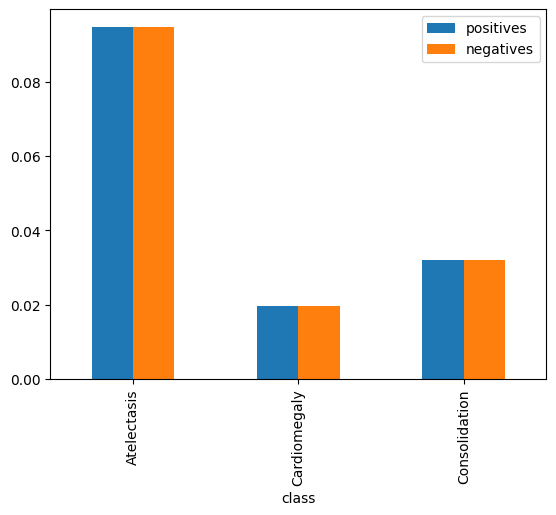

In [37]:
weighted_data_df.plot.bar(x='class')

## Weighted loss calculation to handle class imbalance

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [38]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            y = y_true[:, i]
            f_of_x = y_pred[:, i]

            f_of_x_log = K.log(f_of_x + epsilon)
            f_of_x_1_min_log = K.log((1-f_of_x) + epsilon)

            first_term = pos_weights[i] * y * f_of_x_log
            sec_term = neg_weights[i] * (1-y) * f_of_x_1_min_log
            loss_per_col = - K.mean(first_term + sec_term)
            loss += loss_per_col
        return loss

    return weighted_loss



## Model Development

### Load and Prepare DenseNet121 Model

In [ ]:
#'imagenet',

base_model = DenseNet121(
     include_top=False,
     weights=DENSENET_WEIGHT_PATH, 
     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)  
)
base_model.trainable = False

# After initial training
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# def conv_block(filters):
#     block = tf.keras.Sequential([
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPool2D()
#     ]
#     )
    
#     return block
# def dense_block(units, dropout_rate):
#     block = tf.keras.Sequential([
#         tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
#     ])
    
#     return block

# def build_model():
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPool2D(),
        
#         conv_block(32),
#         conv_block(64),
        
#         conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),
        
#         tf.keras.layers.Dense(len(labels), activation="sigmoid")
#     ])
    
#     return model

In [40]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC'), 
]

In [41]:
tf.keras.backend.clear_session()

LEARNING_RATE = 0.0001
# learning_rate=LEARNING_RATE
EPOCHS = 20
# model = build_model()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
               loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=METRICS)     

# model.summary()

## Model training

## Callbacks

In [42]:
CHECK_POINT_DIR = cfg.OUTPUTS.CHECKPOINT_PATH
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, "ckpt_{epoch}")
LOG_DIR = cfg.OUTPUTS.LOG_DIR

In [43]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True,
                                        save_best_only=True,
                                        monitor='val_loss',
                                        mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
]

In [44]:
for batch in valid_ds.take(1):
    print(batch[0].shape, batch[1].shape)

(32, 320, 320, 3) (32, 3)


In [45]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs = EPOCHS,
                    callbacks=callbacks)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1152, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1246, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/metrics/confusion_metrics.py", line 470, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/utils/metrics_utils.py", line 672, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (1, None, 3) and (None, 3) are incompatible


## Fine-Tune the Model
Right now, our model is sort of smart. We'll change the learning rate so it doesn't jump to conclusions too quickly.

In [ ]:
base_model.trainable = True
fine_tune_at = 149 

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=get_weighted_loss(pos_weights, neg_weights),
    metrics=METRICS
)

# Set the number of epochs for fine-tuning
fine_tune_epochs = 20
total_epochs = EPOCHS + fine_tune_epochs  # Total epochs

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=valid_ds,
    callbacks=callbacks  
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.show()